## Classification Project - Fraud Car Insurance Detection

Using classification models to classify, whether a insurance claim is Fraud or Not

Dataset --> insurance_claims.csv(Taken From Kaggle) (No Data Description Available)

In [1]:
# Importing the Required Labaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import  DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
#Martix library
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")  #--to ignore warnings

#### Load the Dataset

In [2]:
#Loading The Dataset
df1 = pd.read_csv("C:/Users/Akaash/Downloads/insurance_claims.csv")
df1.head(3)

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN


In [3]:
#Checking the shape of Dataset
df1.shape

(1000, 40)

Inference: We have 1000 rows & 40 columns.

#### Drop features that are not required to build our model
Based on My Assumption as Dataset Description is not available

In [4]:
#Dropping
df2 = df1.drop(['months_as_customer','policy_number','policy_bind_date','policy_state', 'policy_csl','insured_zip','insured_education_level',
                'insured_hobbies','insured_occupation','incident_date','incident_state','incident_city','incident_location',
                'incident_hour_of_the_day','auto_model', 'auto_year','_c39','umbrella_limit','capital-gains','capital-loss','auto_make'],
               axis='columns')
df2.shape

(1000, 19)

#### Data Imputation: Handle NA values

In [5]:
#Checking NA Values & Dtypes
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age                          1000 non-null   int64  
 1   policy_deductable            1000 non-null   int64  
 2   policy_annual_premium        1000 non-null   float64
 3   insured_sex                  1000 non-null   object 
 4   insured_relationship         1000 non-null   object 
 5   incident_type                1000 non-null   object 
 6   collision_type               1000 non-null   object 
 7   incident_severity            1000 non-null   object 
 8   authorities_contacted        1000 non-null   object 
 9   number_of_vehicles_involved  1000 non-null   int64  
 10  property_damage              1000 non-null   object 
 11  bodily_injuries              1000 non-null   int64  
 12  witnesses                    1000 non-null   int64  
 13  police_report_avail

Inference: No NA Values Present

#### Now will impute the "?" with "Not Available" in columns 'collision_type','property_damage','police_report_available'

In [6]:
#Imputing 
df2["collision_type"].replace('?', "No info", inplace = True)
df2["property_damage"].replace('?', "Dont Know", inplace = True)
df2["police_report_available"].replace(('?','NO','YES'),("Missing","No","Yes"), inplace = True)

#### Outliers Removal Using Descriptive Stats
A commonly used rule says that a datapoint is an outliers if it is more then 1.5*IQR above the Third Quartile or Below the first Quartile 

In [7]:
#Summary
df2.describe()

,age,policy_deductable,policy_annual_premium,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim
count,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000
mean,38.948000,1136.000000,1256.406150,1.83900,0.992000,1.487000,52761.94000,7433.420000,7399.570000,37928.950000
std,9.140287,611.864673,244.167395,1.01888,0.820127,1.111335,26401.53319,4880.951853,4824.726179,18886.252893
min,19.000000,500.000000,433.330000,1.00000,0.000000,0.000000,100.00000,0.000000,0.000000,70.000000
25%,32.000000,500.000000,1089.607500,1.00000,0.000000,1.000000,41812.50000,4295.000000,4445.000000,30292.500000
50%,38.000000,1000.000000,1257.200000,1.00000,1.000000,1.000000,58055.00000,6775.000000,6750.000000,42100.000000
75%,44.000000,2000.000000,1415.695000,3.00000,2.000000,2.000000,70592.50000,11305.000000,10885.000000,50822.500000
max,64.000000,2000.000000,2047.590000,4.00000,2.000000,3.000000,114920.00000,21450.000000,23670.000000,79560.000000


#### For Age Column

Using Box plots & IQR rule to Remove

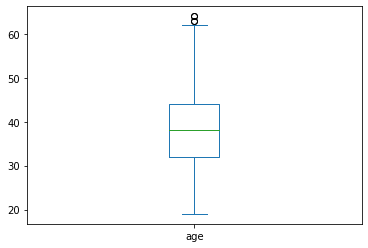

In [8]:
#Boxplot
df2.age.plot(kind = 'box')
plt.show()

Inference: From the Boxplot we can see there are outliers , & Calculated the upper extreme = 62 so any datapoint above 62 are outliers

In [9]:
#Original shape Before Outlier removal
df2.shape

(1000, 19)

In [10]:
# age More then 62
len(df2[df2.age>62])

4

Inference: There are 4 records with age more then 62 so will remove them

In [11]:
#Removing Outliers of age
df3 = df2[~(df2.age>62)]
df3.shape

(996, 19)

#### For policy_annual_premium column
Using Box plots & IQR rule to Remove

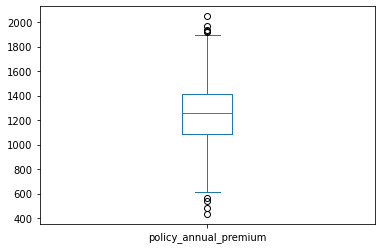

In [12]:
#Boxplot
df3.policy_annual_premium.plot(kind = 'box')
plt.show()

Inference: From the Boxplot we can see there are outliers , & Calculated LE = 600.47 the UE = 1904.82 so any datapoint above these are outliers

In [13]:
#No of policy_annual_premium less then "600.47" 
len(df3[df3.policy_annual_premium<600.47])

4

In [14]:
#Removing Outliers of policy_annual_premium
df4 = df3[~(df3.policy_annual_premium<600.47)]
df4.shape

(992, 19)

In [15]:
#No of policy_annual_premium More then 1904.02
len(df4[df4.policy_annual_premium>1904.82])

5

In [16]:
#Removing Outliers of policy_annual_premium
df5 = df4[~(df4.policy_annual_premium>1904.82)]
df5.shape

(987, 19)

#### For total_claim_amount Column
Using Box plots & IQR rule to Remove

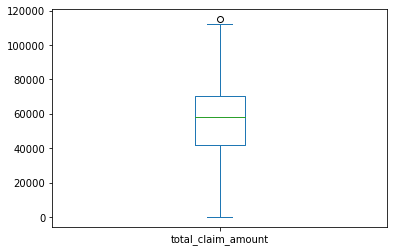

In [17]:
#Boxplot
df5.total_claim_amount.plot(kind = 'box')
plt.show()

Inference: From the Boxplot we can see there are outliers , the UE = 113762.5 so any datapoint above these are outliers

In [18]:
#Removing Outliers of total_claim_amount
df6 = df5[~(df5.total_claim_amount>113762.5)]
df6.shape

(986, 19)

#### For property_claim column
Using Box plots & IQR rule to Remove

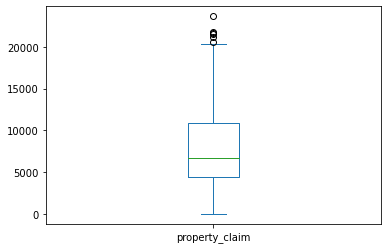

In [19]:
#Boxplot
df6.property_claim.plot(kind = 'box')
plt.show()

Inference: From the Boxplot we can see there are outliers , the UE = 20547.5 so any datapoint above these are outliers

In [20]:
# No of property_claim More then 20547.5
len(df6[df6.property_claim>20547.5])

6

In [21]:
#Removing Outliers of property_claim
df7 = df6[~(df6.property_claim>20547.5)]
df7.shape

(980, 19)

#### Final Dataset After EDA

In [22]:
df7.head(3)

,age,policy_deductable,policy_annual_premium,insured_sex,insured_relationship,incident_type,collision_type,incident_severity,authorities_contacted,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,fraud_reported
0,48,1000,1406.91,MALE,husband,Single Vehicle Collision,Side Collision,Major Damage,Police,1,YES,1,2,Yes,71610,6510,13020,52080,Y
1,42,2000,1197.22,MALE,other-relative,Vehicle Theft,No info,Minor Damage,Police,1,Dont Know,0,0,Missing,5070,780,780,3510,Y
2,29,2000,1413.14,FEMALE,own-child,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,3,NO,2,3,No,34650,7700,3850,23100,N


#### Label Encoding the Y Variable

In [23]:
# let's encode the fraud report to numerical values
df7['fraud_reported'] = df7['fraud_reported'].replace(('N','Y'),(0,1))

#### One Hot Encoding For X Variable

In [24]:
#for insured_sex column
insured_sex_dummies = pd.get_dummies(df7.insured_sex)
insured_sex_dummies.head(3)

,FEMALE,MALE
0,0,1
1,0,1
2,1,0


In [25]:
#for insured_relationship column
insured_relationship_dummies = pd.get_dummies(df7.insured_relationship)
insured_relationship_dummies.head(3)

,husband,not-in-family,other-relative,own-child,unmarried,wife
0,1,0,0,0,0,0
1,0,0,1,0,0,0
2,0,0,0,1,0,0


In [26]:
#for incident_type column
incident_type_dummies = pd.get_dummies(df7.incident_type)
incident_type_dummies.head(3)

,Multi-vehicle Collision,Parked Car,Single Vehicle Collision,Vehicle Theft
0,0,0,1,0
1,0,0,0,1
2,1,0,0,0


In [27]:
#for collision_type column
collision_type_dummies = pd.get_dummies(df7.collision_type)
collision_type_dummies.head()

,Front Collision,No info,Rear Collision,Side Collision
0,0,0,0,1
1,0,1,0,0
2,0,0,1,0
3,1,0,0,0
4,0,1,0,0


In [28]:
#for incident_severity column
incident_severity_dummies = pd.get_dummies(df7.incident_severity)
incident_severity_dummies.head(3)

,Major Damage,Minor Damage,Total Loss,Trivial Damage
0,1,0,0,0
1,0,1,0,0
2,0,1,0,0


In [29]:
#for authorities_contacted column
authorities_contacted_dummies = pd.get_dummies(df7.authorities_contacted)
authorities_contacted_dummies.head(3)

,Ambulance,Fire,None,Other,Police
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1


In [30]:
#for property_damage column
property_damage_dummies = pd.get_dummies(df7.property_damage)
property_damage_dummies.head(3)

,Dont Know,NO,YES
0,0,0,1
1,1,0,0
2,0,1,0


In [31]:
#for police_report_available column
police_report_available_dummies = pd.get_dummies(df7.police_report_available)
police_report_available_dummies.head(3)

,Missing,No,Yes
0,0,0,1
1,1,0,0
2,0,1,0


Inference: Created Dummies Will Merge with original Data

In [32]:
#Concat 
df8 = pd.concat([df7,insured_relationship_dummies,insured_sex_dummies,incident_type_dummies,collision_type_dummies,
                 incident_severity_dummies,authorities_contacted_dummies,property_damage_dummies,police_report_available_dummies],axis='columns')
df8.head(3)

,age,policy_deductable,policy_annual_premium,insured_sex,insured_relationship,incident_type,collision_type,incident_severity,authorities_contacted,number_of_vehicles_involved,...,Fire,None,Other,Police,Dont Know,NO,YES,Missing,No,Yes
0,48,1000,1406.91,MALE,husband,Single Vehicle Collision,Side Collision,Major Damage,Police,1,...,0,0,0,1,0,0,1,0,0,1
1,42,2000,1197.22,MALE,other-relative,Vehicle Theft,No info,Minor Damage,Police,1,...,0,0,0,1,1,0,0,1,0,0
2,29,2000,1413.14,FEMALE,own-child,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,3,...,0,0,0,1,0,1,0,0,1,0


In [33]:
#Dropping the Original Categorial Variable column now

#Final Dataset
final_df = df8.drop(['insured_sex','insured_relationship','incident_type','collision_type','incident_severity',
                     'authorities_contacted','property_damage','police_report_available'],axis="columns")
final_df.head(3)

,age,policy_deductable,policy_annual_premium,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,...,Fire,None,Other,Police,Dont Know,NO,YES,Missing,No,Yes
0,48,1000,1406.91,1,1,2,71610,6510,13020,52080,...,0,0,0,1,0,0,1,0,0,1
1,42,2000,1197.22,1,0,0,5070,780,780,3510,...,0,0,0,1,1,0,0,1,0,0
2,29,2000,1413.14,3,2,3,34650,7700,3850,23100,...,0,0,0,1,0,1,0,0,1,0


#### Train Test Split

In [34]:
#Spliting X & Y Variable
X = final_df.drop('fraud_reported', axis = 1)
Y = final_df['fraud_reported']
#printing shape of both
print("X :",X.shape)
print("Y :",len(Y))

X : (980, 41)
Y : 980


#### Standardization
To Remove Scaling Effect

In [35]:
#Taking only Numerial Variable
num_df = X[['age','policy_deductable','policy_annual_premium','witnesses',
            'number_of_vehicles_involved','bodily_injuries','total_claim_amount','injury_claim','property_claim',
            'vehicle_claim']]

In [36]:
#Standardizing
scaler = StandardScaler()
scaled_data = scaler.fit_transform(num_df)

In [37]:
#Converting the scaled Data into a Dataframe
scaled_num_df = pd.DataFrame(data = scaled_data, columns = num_df.columns, index = X.index)
scaled_num_df.head(3)

,age,policy_deductable,policy_annual_premium,witnesses,number_of_vehicles_involved,bodily_injuries,total_claim_amount,injury_claim,property_claim,vehicle_claim
0,1.011990,-0.229444,0.633900,0.467690,-0.826246,0.009963,0.727273,-0.187482,1.212584,0.758982
1,0.345640,1.405869,-0.257623,-1.333237,-0.826246,-1.210492,-1.812091,-1.366860,-1.390665,-1.824946
2,-1.098116,1.405869,0.660387,1.368153,1.134338,1.230418,-0.683231,0.057450,-0.737726,-0.782756


In [38]:
#Dropping the original columns from the X Dataframe
X.drop(columns = scaled_num_df.columns, inplace = True)

#ConCat X with Scaled Data
X = pd.concat([scaled_num_df, X], axis = 1)
X.head(3)

,age,policy_deductable,policy_annual_premium,witnesses,number_of_vehicles_involved,bodily_injuries,total_claim_amount,injury_claim,property_claim,vehicle_claim,...,Fire,None,Other,Police,Dont Know,NO,YES,Missing,No,Yes
0,1.011990,-0.229444,0.633900,0.467690,-0.826246,0.009963,0.727273,-0.187482,1.212584,0.758982,...,0,0,0,1,0,0,1,0,0,1
1,0.345640,1.405869,-0.257623,-1.333237,-0.826246,-1.210492,-1.812091,-1.366860,-1.390665,-1.824946,...,0,0,0,1,1,0,0,1,0,0
2,-1.098116,1.405869,0.660387,1.368153,1.134338,1.230418,-0.683231,0.057450,-0.737726,-0.782756,...,0,0,0,1,0,1,0,0,1,0


#### Train Test Split

In [39]:
#Spliting into Train Test = 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20,random_state=7)

Inference: The Dataset is split into Train Test with 80% & 20% Respectively

#### Model Building

In [40]:
#Logistic regression and fit the model
classifier = LogisticRegression()
classifier.fit(X_train,Y_train)
classifier.score(X_test, Y_test)

0.7704081632653061

#### Find best Algorithms using GridSearchCV

In [41]:
#GridSearchCV

def find_best_model_using_gridsearchcv(x,y):
    algos = {
        'Logistic' :{'Classifier': LogisticRegression(),'params':{'max_iter': [120,130,150]}
        },
        'Decision Tree': {'Classifier': DecisionTreeClassifier(),'params': {'criterion': ['entropy'],'max_depth': [3,4,5]}
        },
        'Random Forest': {'Classifier': RandomForestClassifier(),'params':{'n_estimators':[100,125,150,175,200],'max_features': [4,5,6],'random_state':[7]}
        },
        'AdaBoost': {'Classifier': AdaBoostClassifier(),'params': {'n_estimators' : [10,15,20],'random_state':[7]}
        },
        'Gradient Boosting': {'Classifier': GradientBoostingClassifier(),'params': {'learning_rate':[0.1,0.01,0.2],'random_state':[7]}
        },
        'XGBM': {'Classifier': XGBClassifier(),'params': {'n_estimators' : [70,80,90,100],'max_depth': [3,4,5,7],
                                                          'learning_rate':[0.1,0.2],'random_state':[7]}
        },
        'SVM': {'Classifier': SVC(),'params': {'kernel':['rbf','poly'],'gamma':[50,100],'C':[10,15,20]}
        },
        'KNN': {'Classifier': KNeighborsClassifier(),'params': {'n_neighbors':[5,10,15,20]}
        }
    }
    scores = []
    kfold = KFold(n_splits=5, random_state=10, shuffle=True)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['Classifier'], config['params'], cv=kfold)
        gs.fit(x,y)
        scores.append({
            'Classifier': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['Classifier','best_score','best_params'])

find_best_model_using_gridsearchcv(X,Y)

[16:51:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:51:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:51:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:51:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:51:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:51:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:51:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:51:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:52:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:52:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:52:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:52:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:52:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:52:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:52:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:52:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:52:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:52:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:52:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:52:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:53:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:53:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:53:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:53:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

,Classifier,best_score,best_params
0,Logistic,0.802041,{'max_iter': 120}
1,Decision Tree,0.797959,"{'criterion': 'entropy', 'max_depth': 3}"
2,Random Forest,0.793878,"{'max_features': 6, 'n_estimators': 175, 'rand..."
3,AdaBoost,0.805102,"{'n_estimators': 10, 'random_state': 7}"
4,Gradient Boosting,0.777551,"{'learning_rate': 0.2, 'random_state': 7}"
5,XGBM,0.788776,"{'learning_rate': 0.2, 'max_depth': 5, 'n_esti..."
6,SVM,0.754082,"{'C': 10, 'gamma': 50, 'kernel': 'rbf'}"
7,KNN,0.758163,{'n_neighbors': 15}


Inference: The Best Algorithm we got from Grid Search is Adaboost so will Create the final Model on Adaboost Algorithms

#### Final Model (Adaboost)

In [42]:
#AdaBoost Classifier and fit the model
Ada_classifier = AdaBoostClassifier(n_estimators=10, random_state=7)
Ada_classifier.fit(X,Y)
#Predict for X dataset
y_pred = classifier.predict(X)

# Confusion Matrix for the model accuracy
confusion_matrix = confusion_matrix(Y,y_pred)
print (confusion_matrix)

[[672  67]
 [106 135]]


In [43]:
#Calculating Accuracy 
#TP+TN / TP + FP + FN + TN
((672+135)/(672+67+106+135))*100

82.34693877551021

Inference: Final Accuracy is 82.34%

#### Testing The Model on New Datapoint

In [44]:
# Function to Gets New input/Datapoint
def classify_fraud(age,policy_deductable,policy_annual_premium,insured_sex,insured_relationship,incident_type,collision_type,incident_severity,
                   authorities_contacted,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,
                   injury_claim,property_claim,vehicle_claim):
    data = {'age':age,'policy_deductable':policy_deductable,'policy_annual_premium':policy_annual_premium,'number_of_vehicles_involved':number_of_vehicles_involved,
            'bodily_injuries':bodily_injuries,'witnesses':witnesses,'total_claim_amount':total_claim_amount,'injury_claim':injury_claim,'property_claim':property_claim,
            'vehicle_claim':vehicle_claim} 
    data_df = pd.DataFrame(data, index = [0])
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data_df)
    scaled_data_df = pd.DataFrame(data = scaled_data, columns = data_df.columns, index = data_df.index)

    ins_index = np.where(X.columns==insured_sex)[0]
    inr_index = np.where(X.columns==insured_relationship)[0]
    ict_index = np.where(X.columns==incident_type)[0]
    cot_index = np.where(X.columns==collision_type)[0]
    ics_index = np.where(X.columns==incident_severity)[0]
    auc_index = np.where(X.columns==authorities_contacted)[0]
    prd_index = np.where(X.columns==property_damage)[0]
    por_index = np.where(X.columns==police_report_available)[0]

    x = np.zeros(len(X.columns))
    x[0] = scaled_data_df.age
    x[1] = scaled_data_df.policy_deductable
    x[2] = scaled_data_df.policy_annual_premium
    x[3] = scaled_data_df.number_of_vehicles_involved
    x[4] = scaled_data_df.bodily_injuries
    x[5] = scaled_data_df.witnesses
    x[6] = scaled_data_df.total_claim_amount
    x[7] = scaled_data_df.injury_claim
    x[8] = scaled_data_df.property_claim
    x[9] = scaled_data_df.vehicle_claim

    if [np.logical_and(ins_index > 0 , ins_index == 0)]:
        x[ins_index] = 1
    if inr_index >= 0:
        x[inr_index] = 1
    if ict_index >= 0:
        x[ict_index] = 1
    if cot_index >= 0:
        x[cot_index] = 1
    if ics_index >= 0:
        x[ics_index] = 1
    if auc_index >= 0:
        x[auc_index] = 1
    if prd_index >= 0:
        x[prd_index] = 1
    if por_index >= 0:
        x[por_index] = 1

    return Ada_classifier.predict([x])[0]


In [45]:
#Checking the First Datapoint
classify_fraud(48,1000,1406.91,'MALE','husband','Single Vehicle Collision','Side Collision','Major Damage','Police',1,'YES',1,2,'Yes',71610,6510,13020,52080)

1

Inference: The Classification was Correct As the First Datapoint has 1 i.e. 'It is Fraud'
Now Lets for Some New Data Point by Changing some Values

In [46]:
#Checking for 2nd DataPoint
classify_fraud(42,2000,1197.22,'MALE','other-relative','Vehicle Theft','No info','Minor Damage','Police',1,'Dont Know',0,0,'Not Available',5070,780,780,3510)

0

In [47]:
#Checking for New Datapoint
classify_fraud(48,1000,1406.91,'MALE','husband','Single Vehicle Collision','Side Collision','Minor Damage','Police',1,'YES',1,2,'Yes',5000,1000,2500,1500)

0

Inference: Checked Different Scenerios the most important variable tht changes the classification are 'collision type', 'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim' as when i changed those so in that cases classification Changed

#### Saving the Trained Model

In [48]:
# .sav file
import pickle
filename = 'C:/Users/Akaash/Downloads/fraud_detection_model.sav'
pickle.dump(Ada_classifier, open(filename, 'wb'))

In [49]:
# .pickle file
with open('C:/Users/Akaash/Downloads/fraud_detections_model.pickle','wb') as f:
    pickle.dump(Ada_classifier,f)

#### Exporting column information to a file that will be useful later on in our Deployment

In [50]:
import json
columns = {
    'data_columns' : [col for col in X.columns]
}
with open("C:/Users/Akaash/Downloads/fraud_columns.json","w") as f:
    f.write(json.dumps(columns))